# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import numpy as np

In [3]:
finance = pd.read_csv("../data/PS_20174392719_1491204439457_log.csv")
print(finance.shape)
finance.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [36]:
finance["isFlaggedFraud"].value_counts() #empty in the sample, but not in total -> so keep it!


0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [37]:
#samle it
n = 100000
finance_sample = finance.sample(n=n, axis=0)
print(finance_sample.shape)
finance_sample.head()

(100000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
873929,42,CASH_OUT,245938.58,C114880637,0.0,0.00,C1262669158,496232.90,742171.48,0,0
1253644,134,CASH_OUT,127900.73,C380309768,10503.0,0.00,C245969082,56223.62,184124.35,0,0
5087416,355,CASH_OUT,62436.31,C2082494007,91775.0,29338.69,C829682895,476132.72,538569.04,0,0
5782972,400,TRANSFER,1002824.91,C375489976,0.0,0.00,C1265935034,16265948.10,17268773.01,0,0
5560569,384,PAYMENT,5880.12,C202170136,616.0,0.00,M1836466498,0.00,0.00,0,0


In [38]:
finance_sample.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [39]:
#finance_sample.describe()

stats = finance_sample.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']
stats['outliers_low'] = (stats['25%'] - 1.5*stats['IQR'])>stats['min']
stats['outliers_up'] = (stats['75%'] + 1.5*stats['IQR'])<stats['max']
stats.transpose()
## Statistics show that a lot of the columns have mostly lower values and outliers on the upper end.
## This might mean that scaling is very important (depending on the algorithm).

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,242.19945,177947.331917,835535.949712,856089.690338,1092547.231855,1213872.554869,0.00129,0.0
std,141.738846,522483.703044,2889941.263654,2923452.491595,3374748.62442,3575851.769414,0.035894,0.0
min,1.0,0.18,0.0,0.0,0.0,0.0,0.0,0.0
25%,155.0,13213.6,0.0,0.0,0.0,0.0,0.0,0.0
50%,237.0,75234.795,14636.0,0.0,132812.895,216390.29,0.0,0.0
75%,333.0,208154.6925,107703.25,143700.545,937284.62,1105541.505,0.0,0.0
max,743.0,38929156.6,57316255.05,47316255.05,302275361.94,302322993.6,1.0,0.0
IQR,178.0,194941.0925,107703.25,143700.545,937284.62,1105541.505,0.0,0.0
outliers_low,False,False,False,False,False,False,False,False


In [40]:
finance_sample.isna().sum() #no null values in the number columns

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [41]:
finance_sample["type"].value_counts() #not many, can be translated into dummies

CASH_OUT    35044
PAYMENT     33751
CASH_IN     22076
TRANSFER     8492
DEBIT         637
Name: type, dtype: int64

In [43]:
finance_sample["nameOrig"].nunique() #99996 -> column can be dropped, all unique values

99996

In [44]:
finance_sample["nameDest"].nunique() #93029 -> column can mabe dropped, too many unique values to be turned into number code
## 93029/len(finance_sample) #--> 93% of data is unique names

92808

In [45]:
finance_sample.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.025246,-0.004706,-0.005338,0.032943,0.030707,0.035545,NaN
amount,0.025246,1.000000,0.001800,-0.006759,0.241713,0.394659,0.115305,NaN
oldbalanceOrg,-0.004706,0.001800,1.000000,0.998549,0.062647,0.039645,0.018461,NaN
newbalanceOrig,-0.005338,-0.006759,0.998549,1.000000,0.064333,0.039500,-0.004798,NaN
oldbalanceDest,0.032943,0.241713,0.062647,0.064333,1.000000,0.979554,0.011949,NaN
newbalanceDest,0.030707,0.394659,0.039645,0.039500,0.979554,1.000000,0.017534,NaN
isFraud,0.035545,0.115305,0.018461,-0.004798,0.011949,0.017534,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\mycro\AppData\Local\Temp\ipykernel_21048\3999707444.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


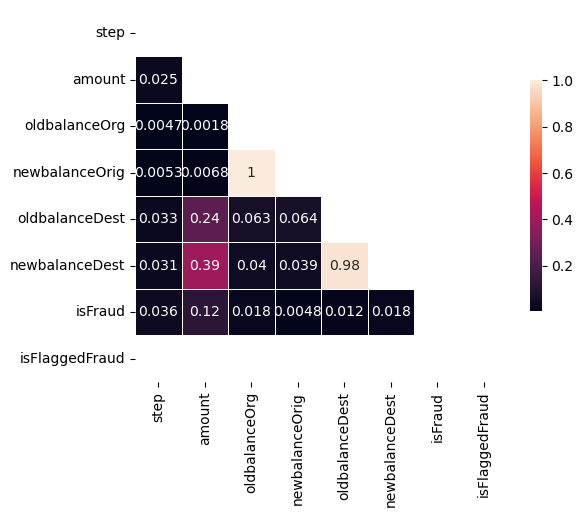

In [46]:
import matplotlib.pyplot as plt
import seaborn as sn
corr=np.abs(finance_sample.corr())
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio (squared -> only positive values)
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

In [ ]:
#there is a perfect correlation between columns newbalanceOrig and oldbalanceOrg -> drop newbalanceOrig because smaller corr with fraud
#there is a high correlation between columns newbalanceDest and oldbalanceDest -> drop newbalanceDest because higher cross corr

### What is the distribution of the outcome? 

In [47]:
# Your response here
#target: isFraud
finance_sample["isFraud"].value_counts() #. plot(kind="bar", figsize=(3,2)) -> sample for fraud too small to visualise

#129/len(finance_sample) #--> 0.00129 --> 0.129% of the sample are fraud
# will have to use re-sampling techniques to get a better result, that also contains this data.

0    99871
1      129
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [ ]:
##from here, start using the real data instead of the sample

In [92]:
# Your code here
# - 1 - first the cleaning
### doing it all with a sample only ###
finance_sample_clean = pd.merge(left = finance_sample, 
                              right = pd.get_dummies(finance_sample["type"], prefix="type"),
                              left_index = True,
                              right_index = True) 
### using all the data ### #this stays commented out if not in use#
# finance_sample_clean = pd.merge(left = finance, 
#                               right = pd.get_dummies(finance["type"], prefix="type"),
#                               left_index = True,
#                               right_index = True) 

finance_sample_clean = finance_sample_clean.drop(columns=["newbalanceOrig", "newbalanceDest", #because of correlation
                                                          "type","type_DEBIT", #because of dummies
                                                          "nameOrig","nameDest" #because of too many unique values
                                                         ])
finance_sample_clean.head()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,21182.0,1,0,0,1,0,0
4,1,11668.14,41554.0,0.0,0,0,0,0,1,0


In [ ]:
# - 2 - then split it into test and train

In [93]:
from sklearn.model_selection import train_test_split

X = finance_sample_clean.drop(columns=["isFraud"])
Y = finance_sample_clean["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15) #smaller test size because big data anyway

In [94]:
X_train.shape #(85000, 9)
X_test.shape  #(15000, 9)
y_train.shape #(85000,)
y_test.shape  #(15000,)

(954393,)

In [95]:
# - 3 - rescale the data, based on the train dataset
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler() #value before min will be 0, max will be 1, everything else somewher in btw.

#do not use the test data for this!! Testdata is not known to the model.
#do the normalizing fitting on all the input train data. 
normalizer.fit(X_train)

#Then use that normalization function on the train data and anything coming later on into the model.
X_train_normalized = normalizer.transform(X_train)
X_test_normalized = normalizer.transform(X_test)

In [96]:
X_train_normalized.shape #(85000, 9)
X_test_normalized.shape  #(15000, 9)
y_train.shape            #(85000,)
y_test.shape             #(15000,)

(954393,)

In [97]:
# - 4 - re-sample, oversample some data
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 0.5, random_state = 0) ## 0.5 Means my minority class will be half has big as my majority class

X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_normalized,y_train)

In [98]:
X_train_SMOTE.shape     #127344, 9)
X_test_normalized.shape #(15000, 9)
y_train_SMOTE.shape     #(127344,)
y_test.shape            #(15000,)

(954393,)

### Run a logistic regression classifier and evaluate its accuracy.

In [71]:
import time

In [99]:
%%time
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression() 
log_reg.fit(X_train_SMOTE, y_train_SMOTE)

print("test data accuracy is", log_reg.score(X_test_normalized,y_test))
print("train data accuracy is", log_reg.score(X_train_SMOTE,y_train_SMOTE)) #no overfitting

C:\Users\mycro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test data accuracy is 0.9593144543180849
train data accuracy is 0.9233926231588261
Wall time: 1min 31s


In [100]:
from sklearn.metrics import classification_report

pred = log_reg.predict(X_test_normalized)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    953143
           1       0.03      0.85      0.05      1250

    accuracy                           0.96    954393
   macro avg       0.51      0.90      0.52    954393
weighted avg       1.00      0.96      0.98    954393



In [101]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)
#this gives the sample counts in these 4 groups:
## True Negative | False Positive
##False Negative |  True Positive

array([[914502,  38641],
       [   189,   1061]], dtype=int64)

In [ ]:
## LogisticRegression
## Result 1 (only using sample = 100000): misses 5 out of 25, recall of 80%. Overall score: 0.92
## Result 2 (using all of the dataset)  : misses 189 out of 1250, recall of 85%. Overall score: 0.96

### Now pick a model of your choice and evaluate its accuracy.

In [103]:
%%time
#DecisionTrees
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 3) #max 3 nodes splitting, chosen after tuning 
tree.fit(X_train_SMOTE, y_train_SMOTE)
print("test data accuracy is", tree.score(X_test_normalized,y_test))
print("train data accuracy is", tree.score(X_train_SMOTE,y_train_SMOTE)) #1 = overfitting completely. too high max_depth with 10.

test data accuracy is 0.9937845311103497
train data accuracy is 0.9021104442713163
Wall time: 17 s


In [104]:
pred = tree.predict(X_test_normalized)
print(classification_report(y_test,pred))
confusion_matrix(y_test, pred)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    953143
           1       0.14      0.72      0.23      1250

    accuracy                           0.99    954393
   macro avg       0.57      0.86      0.62    954393
weighted avg       1.00      0.99      1.00    954393



array([[947556,   5587],
       [   345,    905]], dtype=int64)

In [ ]:
## DecisionTreeClassifier
## Result 1 (only using sample = 100000): misses 2 out of 25, recall of 92%. Overall score: 0.965
## Result 2 (using all of the dataset)  : misses 345 out of 1250, recall of 72%. Overall score: 0.994

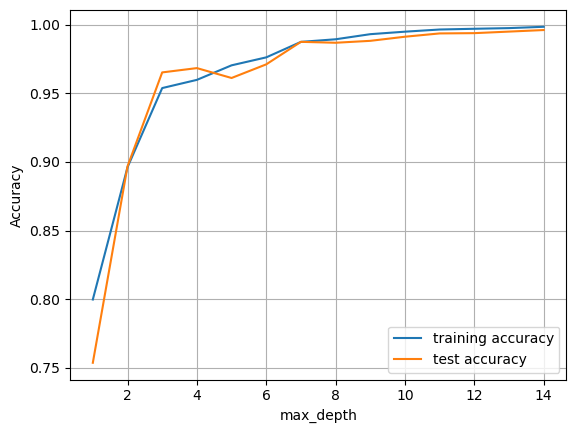

In [78]:
# hyerparameter tuning - find the right max_depth

import matplotlib.pyplot as plt
training_accuracy = []
test_accuracy = []
# try from 1 to 15
max_depth_settings = range(1, 15)
for max_depth in max_depth_settings:
  # build the model
  tree = DecisionTreeClassifier(max_depth=max_depth)
  #training the model
  tree.fit(X_train_SMOTE, y_train_SMOTE)
  # record training set accuracy
  training_accuracy.append(tree.score(X_train_SMOTE, y_train_SMOTE))
  # record generalization accuracy
  test_accuracy.append(tree.score(X_test_normalized, y_test))
plt.plot(max_depth_settings, training_accuracy, label="training accuracy")
plt.plot(max_depth_settings, test_accuracy, label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
plt.grid()
plt.show()

In [105]:
%%time
# B Gradient Boosting - always using DecTrees, no method choosing
#correcting the mistakes done in the previous trees
from sklearn.ensemble import GradientBoostingClassifier

gb_clas = GradientBoostingClassifier(max_depth=3,
                                    n_estimators = 25, #used 100 for the sample, only 25 for the whole data
                                    random_state = 1)
gb_clas.fit(X_train_SMOTE, y_train_SMOTE)
gb_clas.score(X_test_normalized, y_test)

Wall time: 7min 44s


0.9821446720585755

In [106]:
pred = gb_clas.predict(X_test_normalized)
print(classification_report(y_test,pred))
confusion_matrix(y_test, pred)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    953143
           1       0.06      0.85      0.11      1250

    accuracy                           0.98    954393
   macro avg       0.53      0.91      0.55    954393
weighted avg       1.00      0.98      0.99    954393



array([[936295,  16848],
       [   193,   1057]], dtype=int64)

In [ ]:
## GradientBoostingClassifier
## Result 1 (only using sample = 100000): misses 1 out of 25, recall of 96%. Overall score: 0.99
## Result 2 (using all of the dataset)  : misses 193 out of 1250, recall of 85%. Overall score: 0.98

### Which model worked better and how do you know?

In [2]:
# Your response here

# Looking at the sample data, the LogisticRegression was worse than DecisionTreeClassifier was worse than GradientBoostingClassifier.
# That makes sense as I tried hyperparameter tuning only for the decision tree model, not the logistic regression.
# The GradientBoostingClassifier uses the tuned hyperparameter but runs the Decision tree 100 times, so the result is even better.

# How do I recognise a better result? Looking at the overall score on the test data (going up from LogisticRegression to 
# DecisionTreeClassifier), and more importantly, at the recall value (going up from LogisticRegression to DecisionTreeClassifier).
# A higher recall value means there was less False negatives in the prediction, the prediction did not miss so many fraud transfers.

# Looking at the complete data, the DecisionTreeClassifier is worse than the other two (very similar).
# DecisionTreeClassifier has a high overall score, but the recall value goes down to 72%.
# Both of the other models, LogisticRegression and GradientBoostingClassifier, have a better recall rate with 85%.
# The model GradientBoostingClassifier has a higher overall score, meaning that it does less false positive alerts.

# In the end, I would choose GradientBoostingClassifier as my model, as it had the best results with the sampled down data
# and is still in the better group of results with the complete dataset. 

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.